# CZII YOLO11 Training Baseline
 We created a training set adapted to YOLO from [the dataset baseline](https://www.kaggle.com/code/itsuki9180/czii-making-datasets-for-yolo).

In this notebook, we actually use it to train YOLO so that it can infer the xy coordinates of particles through 2D object detection.

# Install and Import modules

In [1]:
# !tar xfvz /kaggle/input/ultralytics-for-offline-install/archive.tar.gz
# !pip install --no-index --find-links=./packages ultralytics
# !rm -rf ./packages

In [2]:
EXP_NAME = "cv_adjust_radius"
LIST_CV = [
    'TS_5_4',
    'TS_69_2',
    'TS_6_4',
    'TS_6_6',
]

PROC_RAW = "proc/yolo11_cv_adjust_radius"

PROC = f"../../{PROC_RAW}"
PROC_YAML = f"/workspace/CZII/{PROC_RAW}"

In [3]:
from tqdm import tqdm
import glob, os
from ultralytics import YOLO

# Prepare to train and instance YOLOmodel

In [4]:
yaml_content = f"""
train: {PROC_YAML}/train.txt
val: {PROC_YAML}/val.txt
nc: 6

# Classes
names:
  0: apo-ferritin
  1: beta-amylase
  2: beta-galactosidase
  3: ribosome
  4: thyroglobulin
  5: virus-like-particle
"""

with open(f'{PROC}/cv_conf.yaml', 'w') as f:
    f.write(yaml_content.strip())

# Let's train YOLO!

In [5]:
def list_all_images(root_dir, extensions="png"):
    """指定ディレクトリ以下の画像ファイルパスを再帰的に取得してリストで返す。"""
    all_paths = []
    search_pattern = os.path.join(root_dir, "**", f"*.{extensions}")
    paths = glob.glob(search_pattern, recursive=True)
    all_paths.extend(paths)
    return all_paths

def contains_val_keyword(path, keyword):
    """
    ファイルパスのファイル名に `keyword` が含まれているか確認。
    Trueならval、Falseならtrainとする。
    """
    filename = os.path.basename(path)  # ディレクトリを除いたファイル名を取得
    return keyword in filename

def extract_train_val_paths(keyword):

    image_paths = list_all_images(f"{PROC_YAML}/images")
    image_paths.sort()
    # print(image_paths)

    train_paths = []
    val_paths   = []

    # ファイル名をみて振り分け
    for p in image_paths:
        if contains_val_keyword(p, keyword):
            val_paths.append(p)
        else:
            train_paths.append(p)

    print(f"Found {len(train_paths)} train images.")
    print(f"Found {len(val_paths)} val images.")

    # train.txt と val.txt に書き出し
    with open(f"{PROC}/train.txt", "w") as f:
        for path in train_paths:
            f.write(path + "\n")

    with open(f"{PROC}/val.txt", "w") as f:
        for path in val_paths:
            f.write(path + "\n")

    print(f"Train list saved to {f"{PROC}/train.txt"}")
    print(f"Val list saved to {f"{PROC}/val.txt"}")

In [6]:
for cv_name in LIST_CV:
    print("="*100)
    print(f"Processing {cv_name}...")
    extract_train_val_paths(cv_name)

    # Load a pretrained model
    model = YOLO("yolo11l.pt")  # load a pretrained model (recommended for training)

    # Train the model
    _ = model.train(
        data=f"{PROC}/cv_conf.yaml",
        name=EXP_NAME,
        epochs=25,
        warmup_epochs=3,
        optimizer='AdamW',
        cos_lr=True,
        lr0=5e-5,
        lrf=0.01,
        imgsz=640,
        device="0",
        weight_decay=0.01,
        batch=16,
        scale=0,
        flipud=0.5,
        fliplr=0.5,
        degrees=90,
        shear=5,
        mixup=0.2,
        copy_paste=0.25,
        seed=8620, # (｡•◡•｡)
    )

Processing TS_5_4...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_cv_adjust_radius/train.txt
Val list saved to ../../proc/yolo11_cv_adjust_radius/val.txt


New https://pypi.org/project/ultralytics/8.3.70 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=../../proc/yolo11_cv_adjust_radius/cv_conf.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=cv_adjust_radius, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=8620, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fals

train: Scanning /workspace/CZII/proc/yolo11_cv_adjust_radius/labels... 1104 images, 272 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:05<00:00, 204.84it/s]

train: New cache created: /workspace/CZII/proc/yolo11_cv_adjust_radius/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: '2.0.2' (you have '2.0.0'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_cv_adjust_radius/labels... 184 images, 30 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 164.34it/s]

val: New cache created: /workspace/CZII/proc/yolo11_cv_adjust_radius/labels.cache


Plotting labels to /workspace/CZII/runs/detect/cv_adjust_radius/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(1c3881e422744df38105d20759d8dd50) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/cv_adjust_radius
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25        11G      2.022      2.344       1.48        467        640: 100%|██████████| 69/69 [00:30<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.91it/s]

                   all        184       2640      0.353      0.541      0.358       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25        11G      1.514      1.469      1.177        497        640: 100%|██████████| 69/69 [00:28<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]

                   all        184       2640      0.495      0.462      0.453      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25        11G       1.43       1.34      1.139        303        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       2640      0.595      0.514      0.519      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25        11G      1.406      1.316      1.123        505        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       2640      0.574       0.55      0.546      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25        11G      1.357      1.257      1.099        528        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       2640      0.594      0.595       0.57       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25        11G      1.333      1.241      1.091        494        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        184       2640      0.645      0.551       0.56      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25        11G      1.313      1.211      1.085        265        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2640      0.624      0.573      0.583       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25        11G      1.307      1.189      1.081        318        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        184       2640      0.595      0.555      0.586      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25        11G      1.294      1.177      1.069        326        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2640      0.614      0.559      0.586      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.1G       1.27      1.153      1.066        390        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       2640      0.596      0.591      0.597      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25        11G      1.255       1.16      1.062        417        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2640      0.625      0.578      0.596      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25        11G      1.258      1.165      1.057        413        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2640        0.6      0.586      0.596      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25        11G       1.24       1.12      1.051        626        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2640      0.589      0.585      0.597      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25        11G      1.235      1.118      1.053        466        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        184       2640       0.56       0.57      0.566      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.1G       1.23      1.114       1.05        331        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        184       2640      0.559      0.582      0.589      0.394


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      10.9G      1.137      1.046      1.009        303        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       2640      0.582       0.56      0.592      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      10.9G      1.136      1.024      1.008        394        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2640      0.589      0.577      0.601        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      10.9G      1.132      1.018      1.006        448        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2640      0.598      0.568      0.596      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25        11G      1.123     0.9993      1.003        282        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.73it/s]

                   all        184       2640      0.602       0.56      0.601      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25        11G      1.106     0.9901     0.9951        368        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2640      0.589      0.576      0.599      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      10.9G      1.098     0.9773     0.9983        338        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2640      0.601      0.579      0.601      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.1G      1.093     0.9678     0.9932        360        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2640        0.6      0.567      0.595      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25        11G      1.094     0.9755      0.993        201        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2640      0.595       0.58      0.599      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      10.9G      1.094     0.9709     0.9943        218        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2640      0.602      0.575      0.597      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      10.9G       1.09     0.9716     0.9914        447        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2640      0.613      0.574      0.598      0.409



25 epochs completed in 0.226 hours.
Optimizer stripped from /workspace/CZII/runs/detect/cv_adjust_radius/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/cv_adjust_radius/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/cv_adjust_radius/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


                   all        184       2640      0.591      0.576      0.599       0.41
          apo-ferritin        133        506      0.673      0.733      0.751      0.461
    beta-galactosidase        112        200      0.398      0.215      0.257      0.164
              ribosome        145        899      0.674      0.732      0.767      0.508
         thyroglobulin        144        749      0.345      0.266      0.257      0.165
   virus-like-particle        105        286      0.864      0.934      0.964       0.75
Speed: 0.6ms preprocess, 16.9ms inference, 0.0ms loss, 10.8ms postprocess per image
Results saved to /workspace/CZII/runs/detect/cv_adjust_radius
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Processing TS_69_2...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_cv_adjust_radius/train.txt
Val list saved to ../../proc/yolo11_cv_adjust_radius/val.txt
New https://pypi.org/

train: Scanning /workspace/CZII/proc/yolo11_cv_adjust_radius/labels... 1104 images, 220 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:05<00:00, 198.59it/s]


train: New cache created: /workspace/CZII/proc/yolo11_cv_adjust_radius/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_cv_adjust_radius/labels... 184 images, 82 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 178.85it/s]

val: New cache created: /workspace/CZII/proc/yolo11_cv_adjust_radius/labels.cache


Plotting labels to /workspace/CZII/runs/detect/cv_adjust_radius2/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(9857c3cf5f8e49999c906cdc0260ab7f) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/cv_adjust_radius2
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.6G       2.03      2.397      1.474        478        640: 100%|██████████| 69/69 [00:31<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.44it/s]

                   all        184       2814      0.607      0.308      0.283      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      11.6G      1.525      1.468       1.18        495        640: 100%|██████████| 69/69 [00:28<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

                   all        184       2814      0.661      0.463      0.477      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      11.6G      1.437      1.359      1.142        274        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.98it/s]

                   all        184       2814      0.524      0.531      0.526       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      11.6G      1.404      1.334      1.124        514        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

                   all        184       2814      0.532      0.522      0.539      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      11.6G      1.359      1.285      1.099        529        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        184       2814      0.527      0.598      0.575      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      11.6G      1.341      1.255      1.096        454        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.98it/s]

                   all        184       2814      0.574      0.552      0.571      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      11.6G      1.318      1.228      1.088        254        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

                   all        184       2814      0.563      0.554      0.568      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      11.6G      1.311      1.201      1.082        316        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  3.00it/s]

                   all        184       2814      0.591      0.545      0.573      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      11.6G       1.31      1.198      1.074        331        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

                   all        184       2814      0.571      0.562      0.575      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.7G      1.271      1.167      1.066        374        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all        184       2814      0.587      0.584      0.577      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      11.6G      1.248      1.158      1.059        427        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]

                   all        184       2814      0.587      0.568       0.58      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      11.6G      1.262      1.164      1.058        408        640: 100%|██████████| 69/69 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

                   all        184       2814       0.59      0.596      0.593      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      11.6G      1.253      1.132      1.054        598        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        184       2814      0.588      0.591      0.587      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.6G      1.241      1.128      1.056        460        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  3.00it/s]

                   all        184       2814      0.607      0.573      0.591      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.7G      1.236      1.132      1.053        359        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all        184       2814      0.592      0.589      0.596      0.395


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      11.5G      1.144      1.057      1.011        337        640: 100%|██████████| 69/69 [00:29<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

                   all        184       2814      0.607      0.584      0.595      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      11.4G       1.14      1.036      1.008        370        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        184       2814      0.605      0.606      0.604      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      11.5G      1.131      1.022      1.005        447        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

                   all        184       2814      0.608      0.601      0.603      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.6G      1.135      1.013      1.008        282        640: 100%|██████████| 69/69 [00:29<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        184       2814      0.604        0.6      0.602      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      11.5G       1.12      1.004      0.998        348        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        184       2814      0.603      0.605      0.598      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.5G      1.105      0.985      0.999        348        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

                   all        184       2814      0.602      0.601      0.599      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.6G      1.103     0.9773     0.9965        361        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all        184       2814      0.604      0.602        0.6      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.6G      1.098     0.9777     0.9939        226        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        184       2814      0.596      0.606      0.602      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      11.5G      1.103     0.9755     0.9959        204        640: 100%|██████████| 69/69 [00:29<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]

                   all        184       2814      0.598      0.602      0.602      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.5G      1.097     0.9718     0.9936        390        640: 100%|██████████| 69/69 [00:28<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all        184       2814      0.598      0.609      0.603      0.416



25 epochs completed in 0.231 hours.
Optimizer stripped from /workspace/CZII/runs/detect/cv_adjust_radius2/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/cv_adjust_radius2/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/cv_adjust_radius2/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


                   all        184       2814      0.604      0.601        0.6      0.418
          apo-ferritin         75        385      0.657      0.699      0.655      0.439
    beta-galactosidase         86        272      0.376      0.272      0.233      0.125
              ribosome         96       1073      0.847      0.764      0.866      0.598
         thyroglobulin        100        850      0.357      0.326      0.287      0.175
   virus-like-particle         56        234      0.783      0.944      0.958      0.755
Speed: 0.2ms preprocess, 8.7ms inference, 0.0ms loss, 16.0ms postprocess per image
Results saved to /workspace/CZII/runs/detect/cv_adjust_radius2
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Processing TS_6_4...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_cv_adjust_radius/train.txt
Val list saved to ../../proc/yolo11_cv_adjust_radius/val.txt
New https://pypi.org/p

train: Scanning /workspace/CZII/proc/yolo11_cv_adjust_radius/labels... 1104 images, 263 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:12<00:00, 88.93it/s] 

train: New cache created: /workspace/CZII/proc/yolo11_cv_adjust_radius/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_cv_adjust_radius/labels... 184 images, 39 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 176.62it/s]

val: New cache created: /workspace/CZII/proc/yolo11_cv_adjust_radius/labels.cache


Plotting labels to /workspace/CZII/runs/detect/cv_adjust_radius3/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(e7ce8564022041b0b2e276cb8c886041) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/cv_adjust_radius3
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.6G      2.067      2.455      1.485        461        640: 100%|██████████| 69/69 [00:30<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]

                   all        184       3998      0.308      0.331      0.241      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      11.7G      1.515       1.53      1.167        471        640: 100%|██████████| 69/69 [00:30<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]

                   all        184       3998      0.501      0.467      0.432      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      11.5G      1.406      1.375      1.122        258        640: 100%|██████████| 69/69 [00:33<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.02it/s]

                   all        184       3998      0.503      0.483      0.476      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      11.6G      1.411      1.335      1.119        446        640: 100%|██████████| 69/69 [00:33<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.06it/s]

                   all        184       3998      0.507      0.539      0.499      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      11.5G      1.367      1.277      1.097        516        640: 100%|██████████| 69/69 [00:29<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.39it/s]

                   all        184       3998      0.527      0.568      0.526        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      11.6G      1.338      1.265      1.088        437        640: 100%|██████████| 69/69 [00:31<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

                   all        184       3998      0.535      0.554      0.524       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      11.6G      1.304      1.237      1.077        205        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  2.00it/s]

                   all        184       3998      0.535      0.536      0.532      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      11.6G      1.289      1.201      1.069        312        640: 100%|██████████| 69/69 [00:29<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       3998      0.532      0.553      0.536      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      11.6G      1.287      1.199      1.063        306        640: 100%|██████████| 69/69 [00:29<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.06it/s]

                   all        184       3998      0.528       0.55      0.534      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.7G      1.273      1.179       1.06        375        640: 100%|██████████| 69/69 [00:28<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       3998       0.54      0.564      0.542      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      11.6G      1.239      1.168       1.05        430        640: 100%|██████████| 69/69 [00:30<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.39it/s]

                   all        184       3998      0.577      0.576      0.552      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      11.6G      1.248      1.173      1.049        383        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       3998      0.575      0.563      0.552      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      11.6G      1.246       1.14      1.047        583        640: 100%|██████████| 69/69 [00:33<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.15it/s]

                   all        184       3998      0.572       0.55      0.547      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.6G       1.22       1.14      1.044        440        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       3998      0.566      0.561      0.555      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.6G      1.225      1.132      1.043        333        640: 100%|██████████| 69/69 [00:30<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       3998      0.553      0.572      0.556      0.361


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      11.5G      1.135      1.067      1.003        326        640: 100%|██████████| 69/69 [00:29<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]

                   all        184       3998      0.559      0.581      0.558       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      11.4G      1.124      1.043     0.9996        370        640: 100%|██████████| 69/69 [00:28<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.69it/s]

                   all        184       3998      0.557      0.577      0.559      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      11.5G      1.121      1.031     0.9959        440        640: 100%|██████████| 69/69 [00:31<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.16it/s]

                   all        184       3998       0.58      0.571      0.563      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.6G      1.114      1.015     0.9946        259        640: 100%|██████████| 69/69 [00:28<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       3998      0.592      0.577      0.562      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      11.5G      1.096      1.007     0.9881        339        640: 100%|██████████| 69/69 [00:29<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.40it/s]

                   all        184       3998      0.566      0.589      0.564      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.5G      1.089     0.9955     0.9889        336        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       3998      0.597      0.573      0.569      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.7G      1.085     0.9877     0.9843        361        640: 100%|██████████| 69/69 [00:30<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       3998      0.606      0.574      0.572      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.6G      1.084     0.9822     0.9844        226        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]

                   all        184       3998      0.604      0.568      0.572      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      11.5G      1.082     0.9816     0.9864        191        640: 100%|██████████| 69/69 [00:28<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       3998        0.6      0.568      0.571       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.5G      1.082      0.981     0.9835        362        640: 100%|██████████| 69/69 [00:29<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all        184       3998      0.604      0.572      0.572       0.37



25 epochs completed in 0.248 hours.
Optimizer stripped from /workspace/CZII/runs/detect/cv_adjust_radius3/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/cv_adjust_radius3/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/cv_adjust_radius3/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


                   all        184       3998      0.603      0.572      0.572       0.37
          apo-ferritin        121        638      0.689      0.747      0.761      0.469
    beta-galactosidase         89        204      0.532      0.173      0.251      0.132
              ribosome        129       2146       0.65      0.857      0.765      0.486
         thyroglobulin        125        750      0.413      0.385      0.342      0.195
   virus-like-particle         75        260      0.732        0.7      0.738      0.565
Speed: 0.2ms preprocess, 6.4ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /workspace/CZII/runs/detect/cv_adjust_radius3
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Processing TS_6_6...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_cv_adjust_radius/train.txt
Val list saved to ../../proc/yolo11_cv_adjust_radius/val.txt
New https://pypi.org/pr

train: Scanning /workspace/CZII/proc/yolo11_cv_adjust_radius/labels... 1104 images, 278 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:05<00:00, 193.37it/s]

train: New cache created: /workspace/CZII/proc/yolo11_cv_adjust_radius/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_cv_adjust_radius/labels... 184 images, 24 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 158.51it/s]


val: New cache created: /workspace/CZII/proc/yolo11_cv_adjust_radius/labels.cache
Plotting labels to /workspace/CZII/runs/detect/cv_adjust_radius4/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(dc58de47eea54ab8b09de09c92cde84a) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/cv_adjust_radius4
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.6G      2.008      2.386      1.465        529        640: 100%|██████████| 69/69 [00:33<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]

                   all        184       2674      0.241      0.499      0.355      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      11.8G      1.499      1.472      1.174        491        640: 100%|██████████| 69/69 [00:28<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]

                   all        184       2674      0.509      0.478      0.476      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      11.6G      1.396      1.353      1.126        261        640: 100%|██████████| 69/69 [00:30<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

                   all        184       2674      0.533      0.504      0.503      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      11.6G      1.408      1.328      1.122        461        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       2674      0.507      0.516       0.54      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      11.6G      1.358      1.257      1.102        541        640: 100%|██████████| 69/69 [00:30<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]

                   all        184       2674      0.544       0.59      0.569      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      11.6G      1.339      1.258      1.096        474        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       2674      0.562      0.588      0.562      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      11.7G      1.301      1.224      1.083        221        640: 100%|██████████| 69/69 [00:30<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       2674      0.573      0.575      0.568      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      11.6G      1.318      1.198      1.084        314        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

                   all        184       2674      0.547      0.578      0.564       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      11.7G      1.322      1.202      1.079        382        640: 100%|██████████| 69/69 [00:30<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       2674      0.516      0.603      0.569      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.8G      1.272      1.156      1.069        384        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

                   all        184       2674      0.572      0.599      0.584      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      11.6G      1.246      1.151       1.06        471        640: 100%|██████████| 69/69 [00:30<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       2674       0.57      0.605       0.59      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      11.6G      1.251      1.164      1.055        421        640: 100%|██████████| 69/69 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        184       2674      0.581       0.61      0.586       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      11.7G       1.26      1.135      1.058        612        640: 100%|██████████| 69/69 [00:29<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       2674      0.553      0.617      0.585      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.6G      1.232      1.129      1.052        482        640: 100%|██████████| 69/69 [00:28<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        184       2674      0.564      0.609      0.581      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.7G      1.233      1.121      1.051        331        640: 100%|██████████| 69/69 [00:29<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       2674      0.564      0.602      0.582      0.386


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      11.6G      1.145      1.057      1.012        326        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       2674       0.58      0.603      0.583      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      11.5G      1.142      1.037      1.009        363        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       2674      0.583      0.609      0.592      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      11.6G       1.14      1.036      1.007        437        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       2674      0.593      0.605      0.595      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.6G      1.142      1.017      1.009        259        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       2674      0.577      0.616      0.588      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      11.6G      1.115      1.001          1        363        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       2674      0.563      0.608      0.589      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.6G      1.108     0.9941      1.001        332        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       2674      0.576      0.609      0.592      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.7G      1.103     0.9827     0.9948        366        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       2674      0.582       0.61      0.592      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.6G      1.097     0.9794     0.9937        226        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       2674      0.578      0.612       0.59      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      11.5G      1.096     0.9714     0.9954        214        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2674      0.576      0.613       0.59      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.5G        1.1     0.9736     0.9943        394        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       2674      0.579      0.613       0.59      0.392



25 epochs completed in 0.258 hours.
Optimizer stripped from /workspace/CZII/runs/detect/cv_adjust_radius4/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/cv_adjust_radius4/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/cv_adjust_radius4/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.17s/it]


                   all        184       2674      0.592      0.604      0.595      0.395
          apo-ferritin        149        451      0.653      0.707      0.677      0.461
    beta-galactosidase         84        187      0.302      0.235      0.194      0.119
              ribosome        106        667      0.787      0.841      0.878       0.49
         thyroglobulin        144        875      0.374       0.34      0.283      0.171
   virus-like-particle        127        494      0.844      0.897      0.943      0.736
Speed: 0.2ms preprocess, 31.7ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /workspace/CZII/runs/detect/cv_adjust_radius4
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


In [7]:
# model = YOLO(f"../../runs/detect/{EXP_NAME}/weights/best.pt")
# metrics = model.val(data=f"{PROC}/czii_conf.yaml", imgsz=640, batch=16, conf=0.25, iou=0.6, device="0", save_json=True)  # no arguments needed, dataset and settings remembered
# print(metrics.box.map)  # map50-95
# print(metrics.box.map50)  # map50
# print(metrics.box.map75)  # map75
# print(metrics.box.maps)

# Prediction example

In [8]:
import pandas as pd
from IPython.display import display, HTML
from IPython.display import Image as IPyImage
pd.options.display.precision = 3

columns = [
    "metrics/precision(B)",
    "metrics/recall(B)",
    "metrics/mAP50(B)",
    "metrics/mAP50-95(B)",
]
df_result = pd.DataFrame(columns=columns)
for i in range(len(LIST_CV)):
    if i == 0:
        df = pd.read_csv(f"../../runs/detect/{EXP_NAME}/results.csv")
    else:
        df = pd.read_csv(f"../../runs/detect/{EXP_NAME}{i+1}/results.csv")
    
    list_results = [
        df.iloc[-1]["metrics/precision(B)"],
        df.iloc[-1]["metrics/recall(B)"],
        df.iloc[-1]["metrics/mAP50(B)"],
        df.iloc[-1]["metrics/mAP50-95(B)"],
    ]
    df_result.loc[f"val_{LIST_CV[i]}"] = list_results
df_result.loc["mean"] = df_result.mean()
df_result

,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B)
val_TS_5_4,0.613,0.574,0.598,0.409
val_TS_69_2,0.598,0.609,0.603,0.416
val_TS_6_4,0.604,0.572,0.572,0.370
val_TS_6_6,0.579,0.613,0.590,0.392
mean,0.598,0.592,0.591,0.397


In [9]:
# 画像を2x2のグリッドで表示
html_content = '''
<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
</div>
'''.format(
    EXP_NAME,
    f"{EXP_NAME}2",
    f"{EXP_NAME}3",
    f"{EXP_NAME}4"
)

display(HTML(html_content))

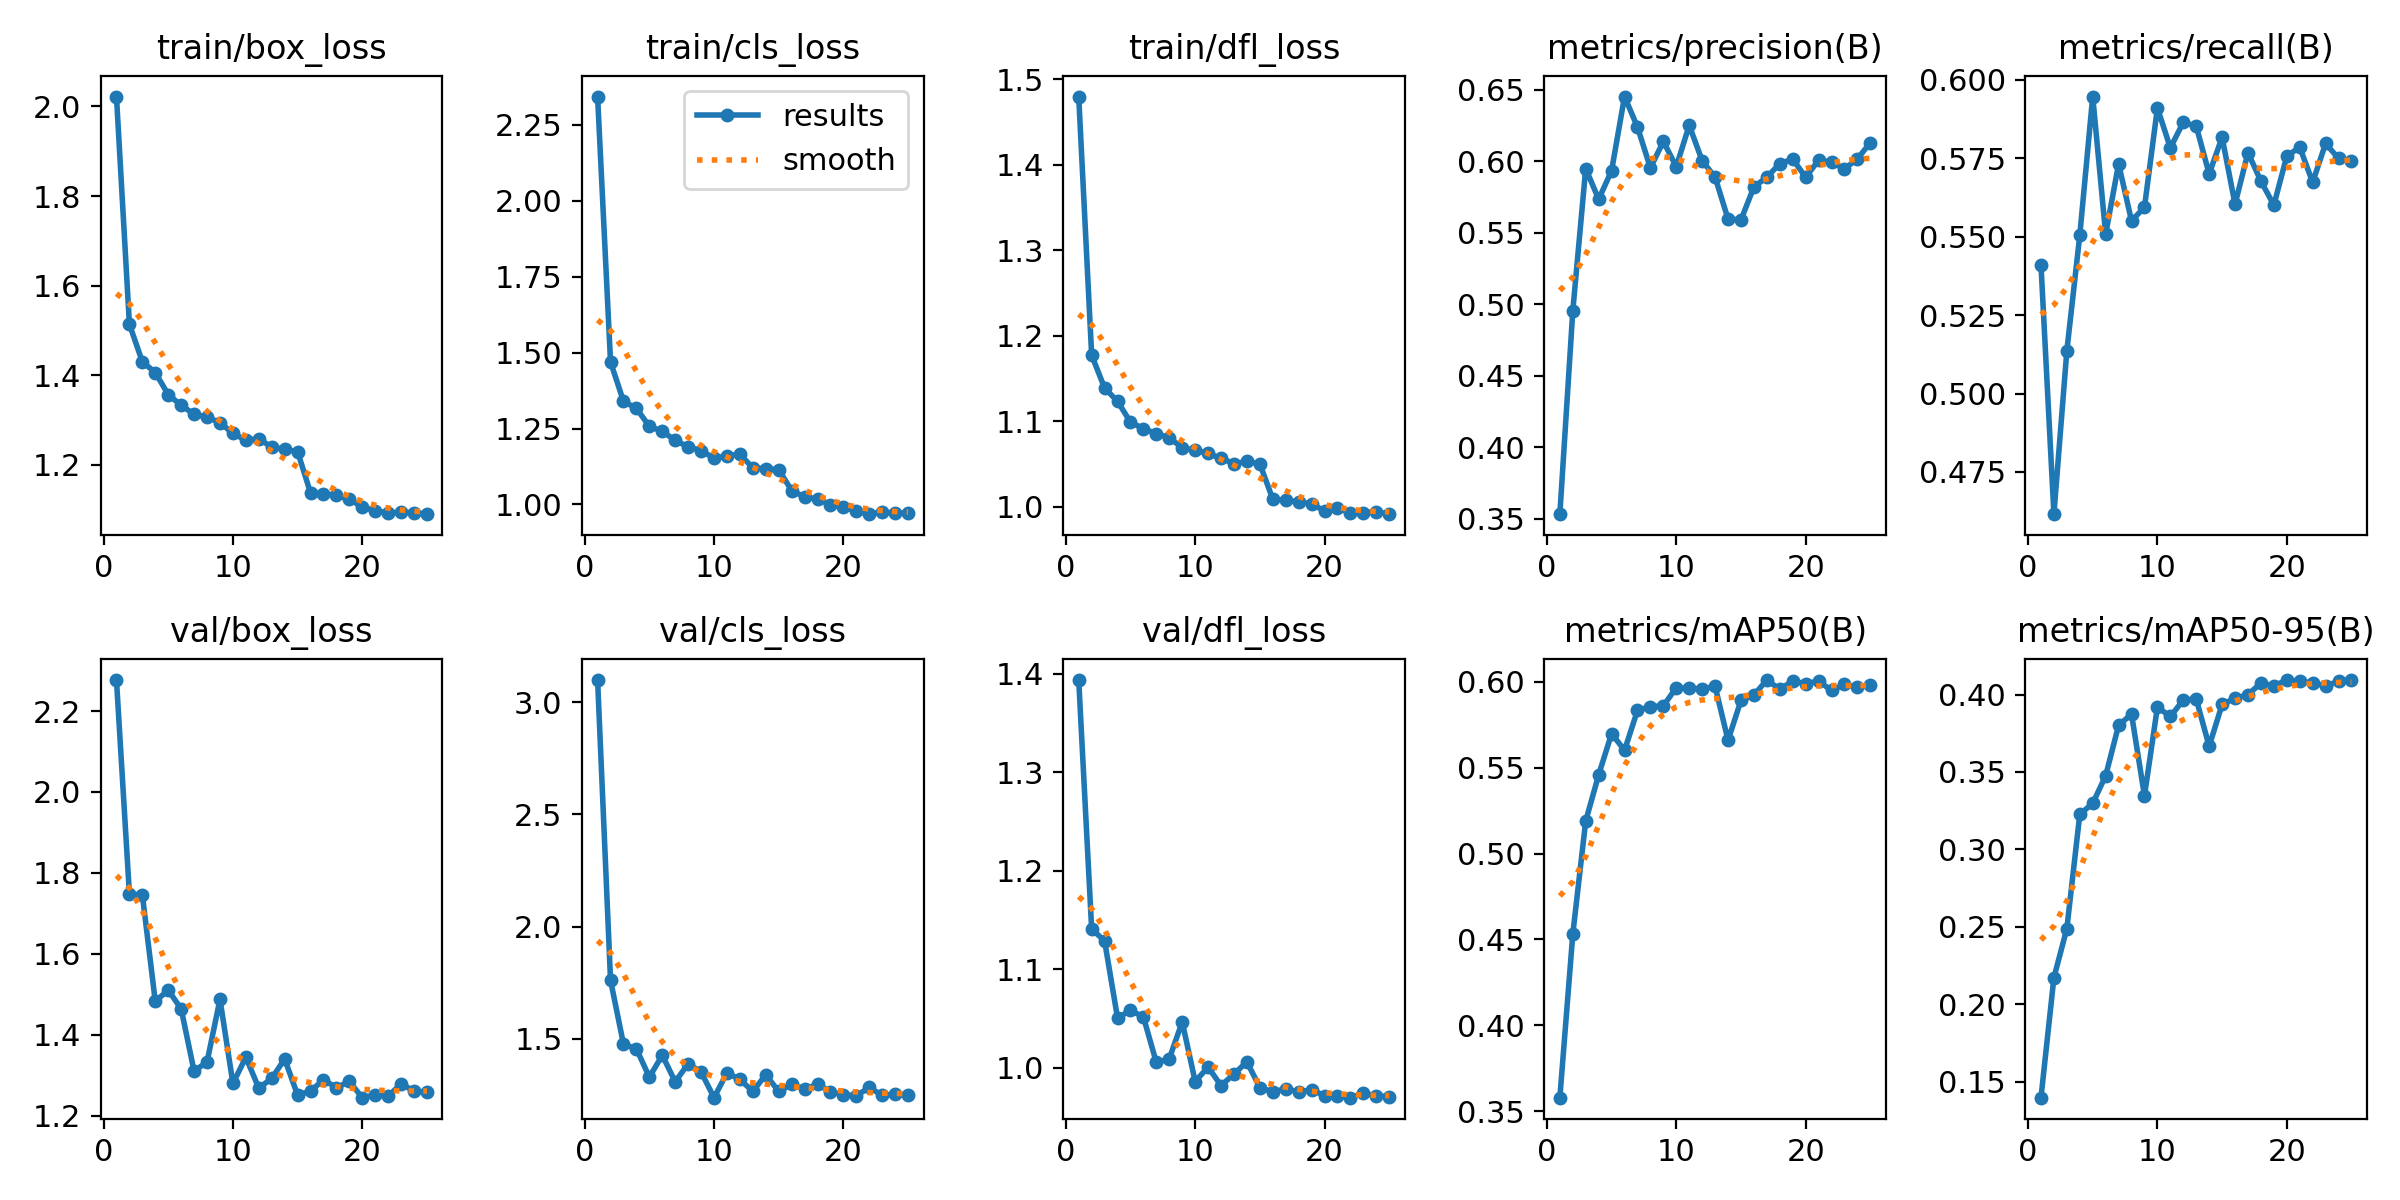

In [10]:
IPyImage(filename=f'../../runs/detect/{EXP_NAME}/results.png', width=800)